In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_util import make_vec_env

In [2]:
# PPO
vec_env = make_vec_env("HalfCheetah-v4")

model = PPO(
    "MlpPolicy",  # Use the Multi-Layer Perceptron (MLP) policy
    vec_env,  # The environment
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,  # Set to 1 to enable verbose output
)
model.learn(total_timesteps=1000000, progress_bar=True)
model.save("ppo_cheetah")

del model # remove to demonstrate saving and loading


Using cpu device


/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -324     |
| time/              |          |
|    fps             | 4424     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------


KeyboardInterrupt: 

In [4]:
model = PPO.load("ppo_cheetah")

obs = vec_env.reset()
rewards_all = []
for i in range(10000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    rewards_all.append(rewards)
    vec_env.render("human")

KeyboardInterrupt: 

In [2]:
# SAC
vec_env = make_vec_env("HalfCheetah-v4", n_envs=4)

model = SAC("MlpPolicy", vec_env, verbose=1, ent_coef=0.2)
model.learn(total_timesteps=100000, progress_bar=True)
model.save("sac_cheetah")

del model # remove to demonstrate saving and loading


Using cpu device


/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -186     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 288      |
|    time_elapsed    | 13       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -3.23    |
|    critic_loss     | 0.398    |
|    ent_coef        | 0.2      |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -197     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 324      |
|    time_elapsed    | 24       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -5.53    |
|    critic_loss     | 0.869    |
|    ent_coef        | 0.2      |
|    learning_

In [9]:
model = SAC.load("sac_cheetah")

obs = vec_env.reset()
rewards_all = []
for i in range(10000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    rewards_all.append(rewards)
    vec_env.render("human")

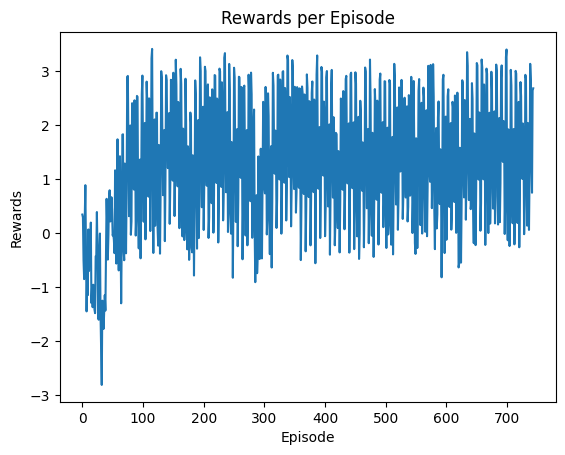

In [5]:
import matplotlib.pyplot as plt

plt.plot(rewards_all)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards per Episode')
plt.show()

# DIAYN

In [2]:
import torch
import torch.nn as nn
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import numpy as np
from network_utils import np2torch


In [3]:

NUM_SKILLS = 10

class SkillDist(nn.Module):
    def __init__(self, num_skills=NUM_SKILLS):
        super(SkillDist, self).__init__()

        self.num_skills = num_skills
        self.p = 1 / num_skills
        self.p_ = torch.tensor([self.p])
        self.dist = torch.distributions.Categorical(probs = torch.ones(num_skills) * self.p)

    def sample(self):
        return self.dist.sample()

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        nn.init.uniform_(self.fc1.weight, -0.01, 0.01)
        nn.init.uniform_(self.fc2.weight, -0.01, 0.01)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.softmax(x, dim=0)
        return x

class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: Env):
        super(CustomEnvWrapper, self).__init__(env)
        self.discriminator = Discriminator(input_size=env.observation_space.shape[0], hidden_size=128, output_size=NUM_SKILLS)
        self.optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)

        self.skill_dist = SkillDist()
        self.skill = self.skill_dist.sample()

        low = np.append(self.observation_space.low, -np.inf)
        high = np.append(self.observation_space.high, np.inf)
        self.observation_space = Box(low, high, dtype=np.float32)
    
    def reset(self, seed=137):
        state = self.env.reset(seed=seed)
        self.skill = self.skill_dist.sample()
        new_state = np.append(state[0], self.skill.item())
        return (new_state, state[1])

    def step(self, action):
        state, reward, done, info, _ = self.env.step(action)
        reward = self.custom_reward_function(action, state, reward)

        state = np.append(state, self.skill.item())

        # Change skill if new trajectory
        if done:
            self.skill = self.skill_dist.sample()

        return state, reward, done, info, _
    
    def custom_reward_function(self, action, state, original_reward):
        a_ = self.discriminator(np2torch(state)) 
        a = torch.log(self.discriminator(np2torch(state)))[self.skill.item()]
        b = torch.log(self.skill_dist.p_)

        # print(a_, a, b)

        r = a - b

        f = -a

        self.optimizer.zero_grad()
        f.backward()
        self.optimizer.step()

        r_ = r.detach().numpy()

        return r_
    
    def cur_skill(self):
        return self.skill.item()

In [69]:
# DIAYN on PPO
env = gym.make("HalfCheetah-v4")
env = CustomEnvWrapper(env)

model = PPO(
    "MlpPolicy",  # Use the Multi-Layer Perceptron (MLP) policy
    env,  # The environment
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,  # Set to 1 to enable verbose output
)
model.learn(total_timesteps=100000)
model.save("diayn_ppo_cheetah")

del model # remove to demonstrate saving and loading


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.79e+03 |
| time/              |          |
|    fps             | 1033     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.04e+03     |
| time/                   |              |
|    fps                  | 807          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0095962845 |
|    clip_fraction        | 0.0914       |
|    clip_range           | 0.2          |
|    en

In [ ]:
model = PPO.load("diayn_ppo_cheetah")

obs = env.reset()
rewards_all = []
for i in range(10000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    rewards_all.append(rewards)
    vec_env.render("human")

In [11]:
model = PPO.load("diayn_ppo_cheetah")
env = gym.make("HalfCheetah-v4", render_mode="human")
env = CustomEnvWrapper(env)

obs, _ = env.reset()
print(env.cur_skill())
# env.skill = env.skill_dist.sample() # Replace <desired_skill> with the skill you want to use
rewards_all = []
for i in range(10000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info, _ = env.step(action)
    rewards_all.append(rewards)
    # env.render()

    if dones:
        break  

1


KeyboardInterrupt: 

In [10]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 4

model = PPO.load("diayn_ppo_cheetah")

env = gym.make("HalfCheetah-v4", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="cheetah-diayn", name_prefix="eval",
                  episode_trigger=lambda x: True)
# env = RecordEpisodeStatistics(env)
env = CustomEnvWrapper(env)

for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    print(env.cur_skill())

    episode_over = False
    while not episode_over:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


1
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-0.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-0.mp4
7
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-1.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-1.mp4
3
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-2.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-2.mp4
6
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-3.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn/eval-episode-3.mp4


/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.time_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.time_queue` for environment variables or `env.get_wrapper_attr('time_queue')` that will search the reminding wrappers.
  logger.warn(


AttributeError: 'HalfCheetahEnv' object has no attribute 'time_queue'